# Exploratory Analysis
This notebook contains the exploratory analysis that will be developed on to produce models.

### Imports

In [1]:
import datahandler.JHU
import datahandler.WorldBank

import datetime as dt
import numpy as np
import pandas as pd

In [2]:
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [3]:
'+'.join([pio.renderers.default, "iframe"])

'plotly_mimetype+notebook+iframe'

In [4]:
pio.renderers.default = pio.renderers.default + "+iframe"

## High-level examination

In [5]:
country_level_data = datahandler.JHU.global_case_data()

In [6]:
latest_wb_pop = datahandler.WorldBank.latest_worldbank("SP.POP.TOTL")

First we look at the current top-level global trend.

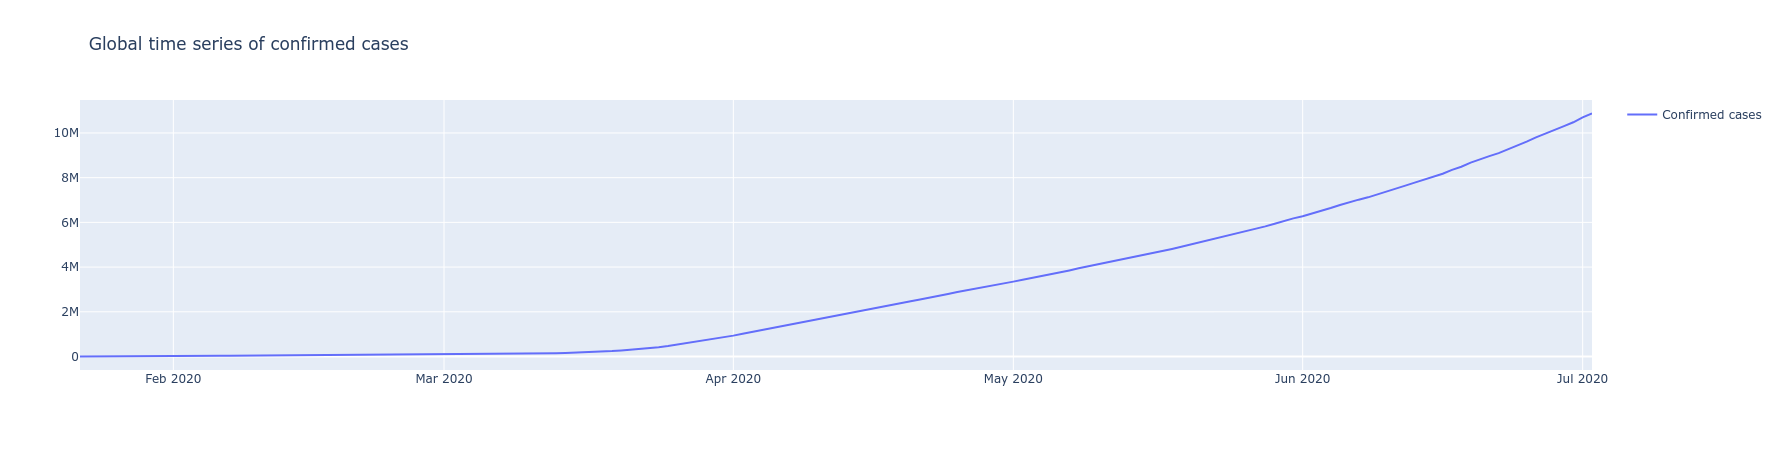

In [7]:
import plotly.graph_objects as go

fig = go.Figure(data = go.Scatter(x=country_level_data.index,
                                   y=country_level_data.sum(axis=1),
                                   name='Confirmed cases'
                                  )
               ).update_layout(title='Global time series of confirmed cases',
                               showlegend=True
                              )
fig.show()

Overall, the graph seems to be climbing steadily, possibly exponential at first, then linear? We will therefore plot a log-graph of the cases. An exponential trend should be approximately linear on a log-graph, while a linear trend would appear logarithmic (as all things should be).

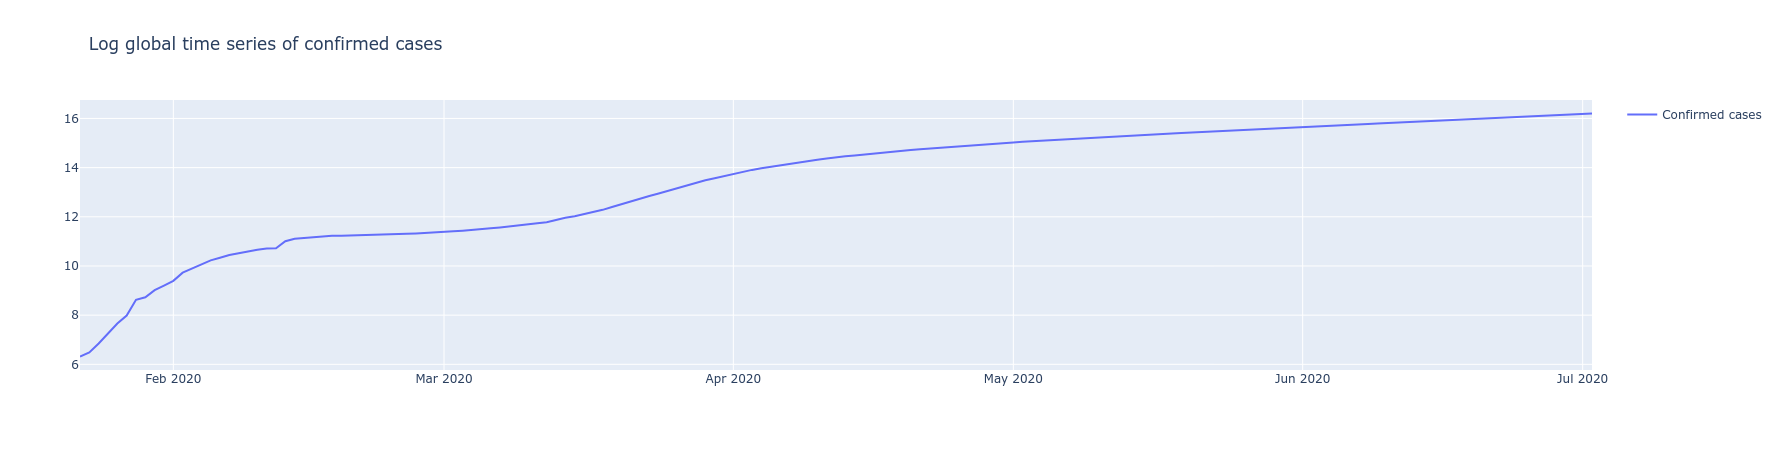

In [8]:
fig = go.Figure(data = go.Scatter(x=country_level_data.index,
                                   y=np.log(country_level_data.sum(axis=1)),
                                   name='Confirmed cases'
                                  )
               ).update_layout(title='Log global time series of confirmed cases',
                               showlegend=True
                              )
fig.show()

The logarithmic graph shows a few more interesting insights.

The initial period does appear linear, but it tails off almost linearly before experiencing a jump from 12 February to 13 February. This is of course due to the change in reporting that China adopted on that date. This gives us our first notice that we need to pay attention to such reporting discrepancies, especially since they add additional noise to the data.

The trend then starts to increase again, first linearly before a change in gradient around 12 March, when European countries started to experience their own exponential growth stage. This tails off again to a logarithmic trend after, at around the beginning of April. The trend thereafter is harder to discern visually. 

The overall trend is harder to discern, since it is comprised of different countries with their own infection patterns, with some countries/regions seeing infections rise at different times, e.g. the original spread in China vs the subsequent spread in Europe, and then in the Americas.

## Country-level breakdown
First, we try to align the case numbers meaningfully. 
### Day 0 alignment
In this case, we treat the last day on which there were no cases reported as day 0. 

In [9]:
country_level_data

Country/Region  Afghanistan  Albania  Algeria  Andorra  Angola  \
2020-01-22                0        0        0        0       0   
2020-01-23                0        0        0        0       0   
2020-01-24                0        0        0        0       0   
2020-01-25                0        0        0        0       0   
2020-01-26                0        0        0        0       0   
...                     ...      ...      ...      ...     ...   
2020-06-28            30967     2402    13273      855     267   
2020-06-29            31238     2466    13571      855     276   
2020-06-30            31517     2535    13907      855     284   
2020-07-01            31836     2580    14272      855     291   
2020-07-02            32022     2662    14657      855     315   

Country/Region  Antigua and Barbuda  Argentina  Armenia  Australia  Austria  \
2020-01-22                        0          0        0          0        0   
2020-01-23                        0          0        0          0        0   
2020-01-24                        0          0        0          0        0   
2020-01-25                        0          0        0          0        0   
2020-01-26                        0          0        0          4        0   
...                             ...        ...      ...        ...      ...   
2020-06-28                       69      59933    24645       7764    17654   
2020-06-29                       69      62268    25127       7834    17723   
2020-06-30                       69      64530    25542       7920    17766   
2020-07-01                       69      67197    26065       8001    17873   
2020-07-02                       69      69941    26658       8066    17941   

Country/Region  ...  United Kingdom  Uruguay  Uzbekistan  Venezuela  Vietnam  \
2020-01-22      ...               0        0           0          0        0   
2020-01-23      ...               0        0           0          0        2   
2020-01-24      ...               0        0           0          0        2   
2020-01-25      ...               0        0           0          0        2   
2020-01-26      ...               0        0           0          0        2   
...             ...             ...      ...         ...        ...      ...   
2020-06-28      ...          312640      929        7948       5297      355   
2020-06-29      ...          313470      932        8222       5530      355   
2020-06-30      ...          314160      936        8503       5832      355   
2020-07-01      ...          314992      943        8781       6062      355   
2020-07-02      ...          285268      947        9078       6273      355   

Country/Region  West Bank and Gaza  Western Sahara  Yemen  Zambia  Zimbabwe  
2020-01-22                       0               0      0       0         0  
2020-01-23                       0               0      0       0         0  
2020-01-24                       0               0      0       0         0  
2020-01-25                       0               0      0       0         0  
2020-01-26                       0               0      0       0         0  
...                            ...             ...    ...     ...       ...  
2020-06-28                    1990              10   1118    1557       567  
2020-06-29                    2185              10   1128    1568       574  
2020-06-30                    2428              10   1158    1594       591  
2020-07-01                    2758              10   1190    1632       605  
2020-07-02                    3080              10   1221    1632       617  

[163 rows x 188 columns]

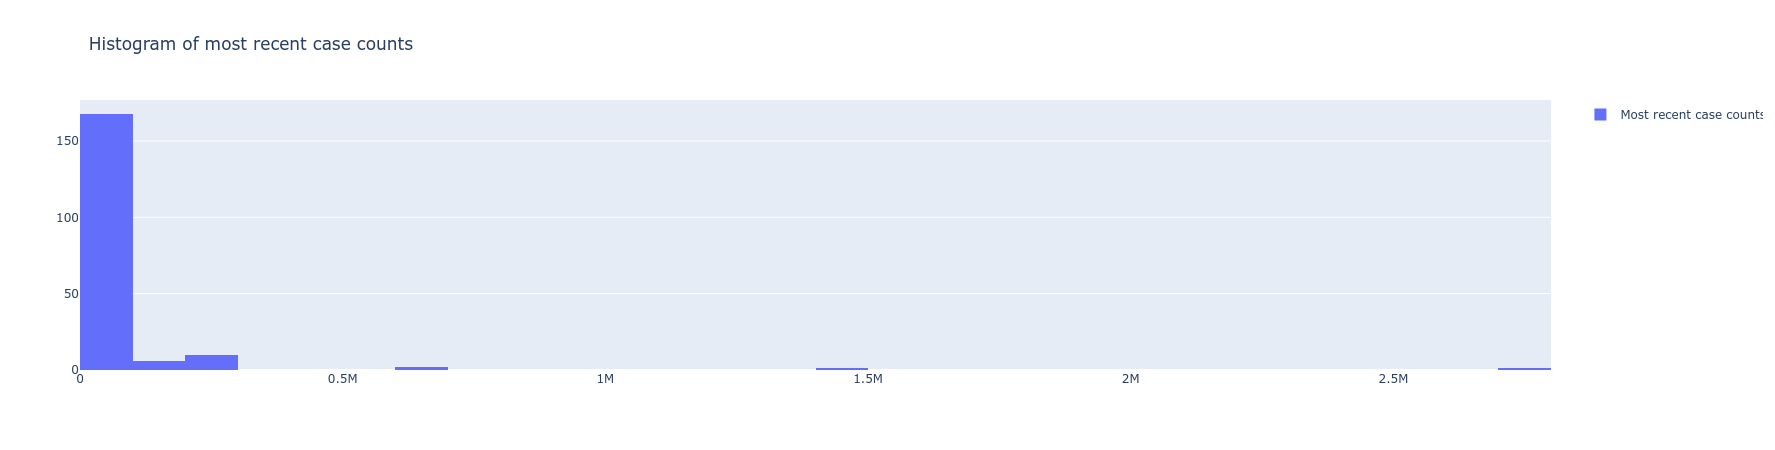

In [10]:
fig = go.Figure(data=[go.Histogram(x=country_level_data.iloc[-1, :],
                                   name='Most recent case counts'
                                  ),
                     ]).update_layout(title='Histogram of most recent case counts',
                                      showlegend=True
                                     )
fig.show()

In [11]:
def first_crossed(df, threshold):
    '''Takes a "tidy" dataframe and a threshold, and returns the date after which the values exceed the threshold.
    
    
    '''
    def inner_first_crossed(series, threshold):
        try:
            result = series[series > threshold].index[0]
            return result
        except IndexError:
            return np.nan
        
    result = df.apply(func=inner_first_crossed, args=[threshold]).dropna()
    return result

In [12]:
first_crossed(country_level_data, 1)

Country/Region
Afghanistan           2020-03-08
Albania               2020-03-09
Algeria               2020-03-02
Andorra               2020-03-16
Angola                2020-03-21
                         ...    
West Bank and Gaza    2020-03-05
Western Sahara        2020-04-05
Yemen                 2020-04-29
Zambia                2020-03-18
Zimbabwe              2020-03-21
Length: 188, dtype: object

In [13]:
def align_cases(df, threshold):
    '''
    
    '''
    temp = first_crossed(df, threshold)
    result = pd.DataFrame(data=[df[x][temp[x]-dt.timedelta(1):].values for x in temp.index]).transpose()
    result.columns = [x for x in temp.index]
    return result

In [14]:
align_cases(country_level_data, 1)

Afghanistan  Albania  Algeria  Andorra  Angola  Antigua and Barbuda  \
0            1.0      0.0      1.0      1.0     1.0                  1.0   
1            4.0      2.0      3.0      2.0     2.0                  3.0   
2            4.0     10.0      5.0     39.0     2.0                  3.0   
3            5.0     12.0     12.0     39.0     3.0                  3.0   
4            7.0     23.0     12.0     53.0     3.0                  7.0   
..           ...      ...      ...      ...     ...                  ...   
158          NaN      NaN      NaN      NaN     NaN                  NaN   
159          NaN      NaN      NaN      NaN     NaN                  NaN   
160          NaN      NaN      NaN      NaN     NaN                  NaN   
161          NaN      NaN      NaN      NaN     NaN                  NaN   
162          NaN      NaN      NaN      NaN     NaN                  NaN   

     Argentina  Armenia  Australia  Austria  ...  United Kingdom  Uruguay  \
0          1.0      1.0        0.0      0.0  ...             0.0      0.0   
1          2.0      4.0        4.0      2.0  ...             2.0      4.0   
2          8.0      8.0        5.0      2.0  ...             2.0      6.0   
3         12.0     18.0        5.0      3.0  ...             2.0      8.0   
4         12.0     26.0        6.0      3.0  ...             2.0     29.0   
..         ...      ...        ...      ...  ...             ...      ...   
158        NaN      NaN     8001.0      NaN  ...             NaN      NaN   
159        NaN      NaN     8066.0      NaN  ...             NaN      NaN   
160        NaN      NaN        NaN      NaN  ...             NaN      NaN   
161        NaN      NaN        NaN      NaN  ...             NaN      NaN   
162        NaN      NaN        NaN      NaN  ...             NaN      NaN   

     Uzbekistan  Venezuela  Vietnam  West Bank and Gaza  Western Sahara  \
0           1.0        0.0      0.0                 0.0             0.0   
1           6.0        2.0      2.0                 4.0             4.0   
2          10.0       10.0      2.0                 7.0             4.0   
3          15.0       17.0      2.0                16.0             4.0   
4          23.0       33.0      2.0                16.0             4.0   
..          ...        ...      ...                 ...             ...   
158         NaN        NaN    355.0                 NaN             NaN   
159         NaN        NaN    355.0                 NaN             NaN   
160         NaN        NaN    355.0                 NaN             NaN   
161         NaN        NaN    355.0                 NaN             NaN   
162         NaN        NaN    355.0                 NaN             NaN   

     Yemen  Zambia  Zimbabwe  
0      1.0     0.0       1.0  
1      6.0     2.0       3.0  
2      6.0     2.0       3.0  
3      7.0     2.0       3.0  
4     10.0     2.0       3.0  
..     ...     ...       ...  
158    NaN     NaN       NaN  
159    NaN     NaN       NaN  
160    NaN     NaN       NaN  
161    NaN     NaN       NaN  
162    NaN     NaN       NaN  

[163 rows x 188 columns]

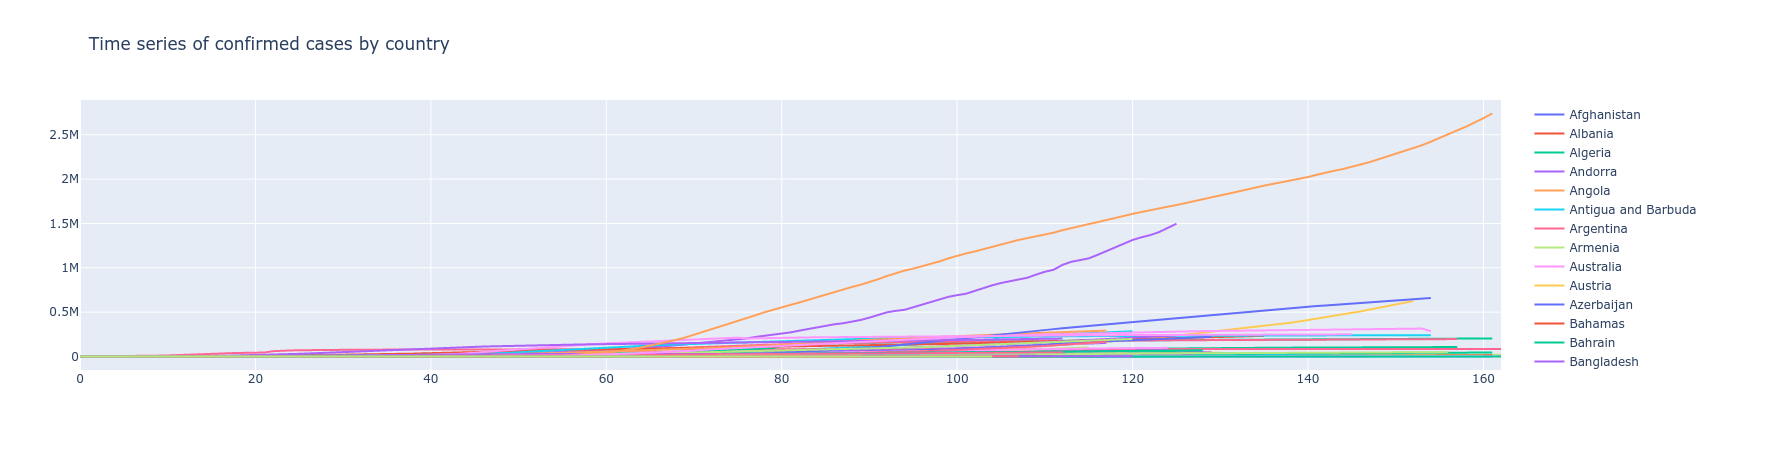

In [15]:
#def generate_scatter_from_column

aligned_1 = align_cases(country_level_data, 1)

fig = go.Figure(data = [go.Scatter(x=aligned_1.index,
                                   y=aligned_1[country].values,
                                   name=country
                                  ) for country in aligned_1.columns]
               ).update_layout(title='Time series of confirmed cases by country',
                               showlegend=True
                              )
fig.show()

The graph appears to show 2 outlier paths, as is rather well known, in the form of the US and Brazil. Apart from that however, most paths are fairly shallow. At this point, fitting a simple linear model regressing on past values would be of interest, as a baseline. While we would expect it to be far out, it can serve as the basis for more sophisticated models.

#### Linear model
This section makes the following assumptions:
* There are no population differences between countries.
    * While this is demonstrably false, a correction requires at the minimum a regression for each country, or additional population information (which will be introduced in later models).
* 2 weeks is sufficient data (the incubation period tends to be around 2 weeks or less). 
* That the dataset starts after some countries have already had cases recorded doesn't matter, since it's mostly the sequences that matter.

This section therefore aims to take the following steps:
1. Create the dataset for the regression.
    * While this is a straightforward model and may not require a validation set, one will be set up anyway so that other models (e.g. cross-validation) can be trained, and used for evaluation on the test set.
    * An arbitrary 60-20-20 split will be used for the train-validation-test split.
        * Because the split involves a time series, the split will have to take place in sequential order (train set before validation, validation set before test), so that the model can retain its usefulness for prediction of future values.
            * The data will be split for each country first, before being added together, to preserve the balance of classes (again, for potential future use).
2. Fit the model on the training set.
3. Test the model on the test set, collecting the MSE.

In [16]:
def train_val_test_split(df, seq_length: int):
    '''Splits the input dataframe into train, validation, and test. This function first defines an inner function that operates on a column, returning three dataframes containing the respective sets.
    '''
    def _process_column(df, seq_length: int, col: str):
        print(f"Processing: {col}")
        temp = df[col].dropna()
        n = len(temp) - seq_length + 1
        result = [temp[x:x+seq_length] for x in range(n)]
        test_len = int(n/5)
        train_len = n - (2 * test_len)
        return (result[:train_len], result[train_len:train_len+test_len], result[train_len+test_len:])
    
    train_set = []
    val_set = []
    test_set = []
    
    for col in df.columns:
        train_temp, val_temp, test_temp = _process_column(df, seq_length, col)
        train_set += train_temp
        val_set += val_temp
        test_set += test_temp
        
    train_set = pd.DataFrame([x.reset_index(drop=True) for x in train_set])
    val_set = pd.DataFrame([x.reset_index(drop=True) for x in val_set])
    test_set = pd.DataFrame([x.reset_index(drop=True) for x in test_set])
    return train_set, val_set, test_set

In [17]:
train_df, val_df, test_df = train_val_test_split(aligned_1, 14)
train_val_df = train_df.append(val_df)

Processing: Afghanistan
Processing: Albania
Processing: Algeria
Processing: Andorra
Processing: Angola
Processing: Antigua and Barbuda
Processing: Argentina
Processing: Armenia
Processing: Australia
Processing: Austria
Processing: Azerbaijan
Processing: Bahamas
Processing: Bahrain
Processing: Bangladesh
Processing: Barbados
Processing: Belarus
Processing: Belgium
Processing: Belize
Processing: Benin
Processing: Bhutan
Processing: Bolivia
Processing: Bosnia and Herzegovina
Processing: Botswana
Processing: Brazil
Processing: Brunei
Processing: Bulgaria
Processing: Burkina Faso
Processing: Burma
Processing: Burundi
Processing: Cabo Verde
Processing: Cambodia
Processing: Cameroon
Processing: Canada
Processing: Central African Republic
Processing: Chad
Processing: Chile
Processing: China
Processing: Colombia
Processing: Comoros
Processing: Congo (Brazzaville)
Processing: Congo (Kinshasa)
Processing: Costa Rica
Processing: Cote d'Ivoire
Processing: Croatia
Processing: Cuba
Processing: Cyprus

In [18]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

regr = linear_model.LinearRegression()
regr.fit(train_df.iloc[:, :-1], train_df.iloc[:, -1])

LinearRegression()

In [19]:
train_y_pred = regr.predict(train_df.iloc[:, :-1])
print(f"Training set MSE: {mean_squared_error(train_df.iloc[:, -1], train_y_pred)}")
print(f"Training set R^2: {r2_score(train_df.iloc[:, -1], train_y_pred)}")

Training set MSE: 211787.3128775958
Training set R^2: 0.9999115178966183


In [20]:
test_y_pred = regr.predict(test_df.iloc[:, :-1])
print(f"Test set MSE: {mean_squared_error(test_df.iloc[:, -1], test_y_pred)}")
print(f"Test set R^2: {r2_score(test_df.iloc[:, -1], test_y_pred)}")

Test set MSE: 1411357.6737669033
Test set R^2: 0.9999718646300028


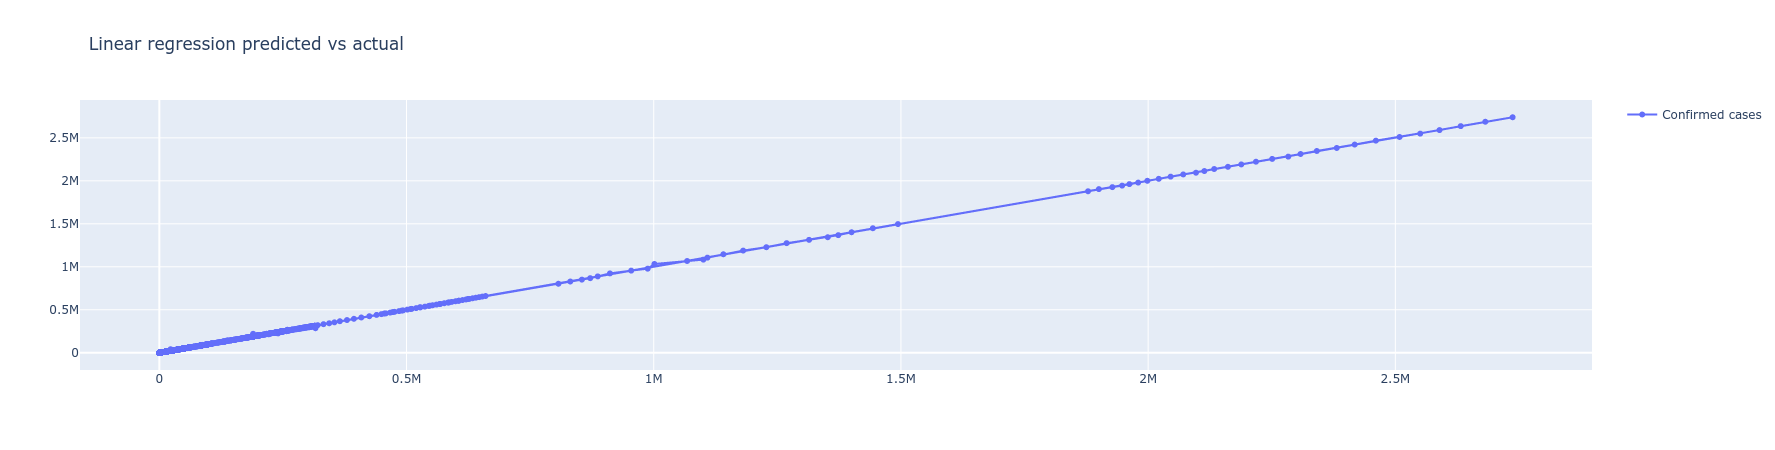

In [21]:
fig = go.Figure(data = go.Scatter(x=test_y_pred,
                                  y=test_df.iloc[:, -1],
                                  mode='lines+markers',
                                  name='Confirmed cases'
                                 )
               ).update_layout(title='Linear regression predicted vs actual',
                               showlegend=True
                              )
fig.show()

Immediately, a problem can be noticed. $R^2$ and MSE do not seem to be very good metrics to use to evaluate the suitability of this regression model. The MSE would be heavily biased by the larger values, as a missed prediction of 1% would be vastly different for predicted values of 1,000 (10), vs 1,000,000 (10,000). In this case, given that the case count is expected to keep increasing, with a range of case counts from the low hundreds to the millions, the MSE could mask the problems with predictions of lower values. If this is the case, we need to find a metric which will measure the value of the error relative to the value of the actual/predicted counts.

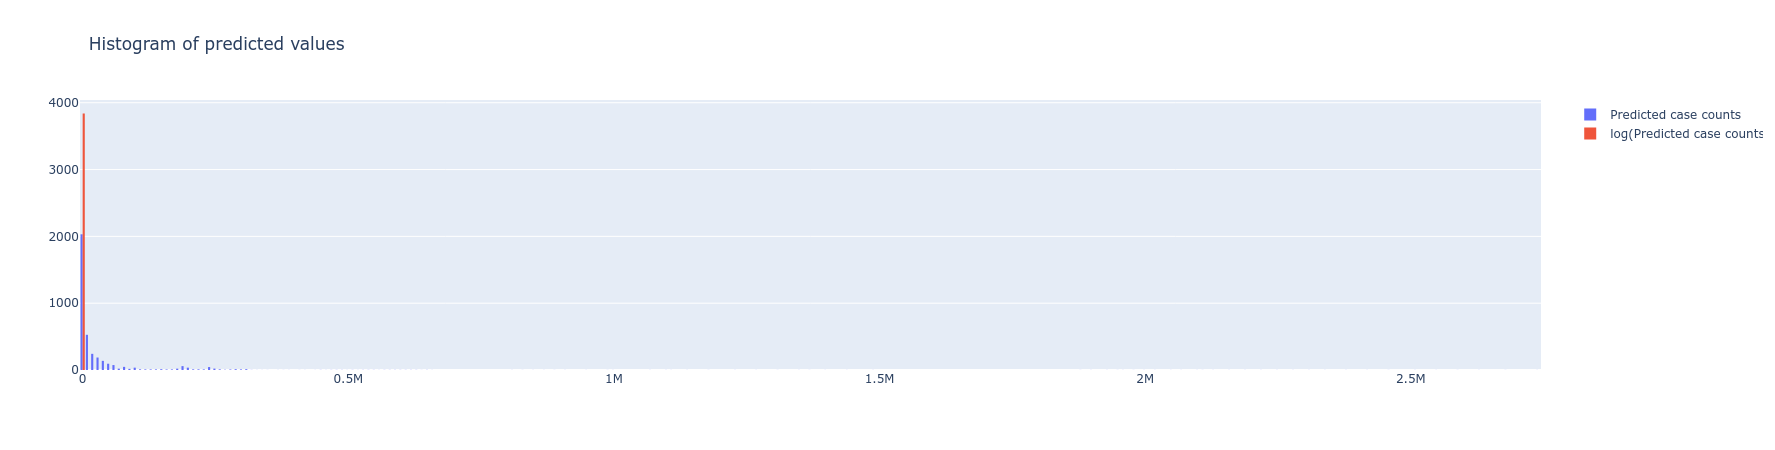

In [22]:
fig = go.Figure(data=[go.Histogram(x=test_y_pred,
                                   name='Predicted case counts'
                                  ),
                      go.Histogram(x=np.log(test_y_pred),
                                  name='log(Predicted case counts)'
                                  )
                     ]).update_layout(title='Histogram of predicted values',
                                      showlegend=True
                                     )
fig.show()

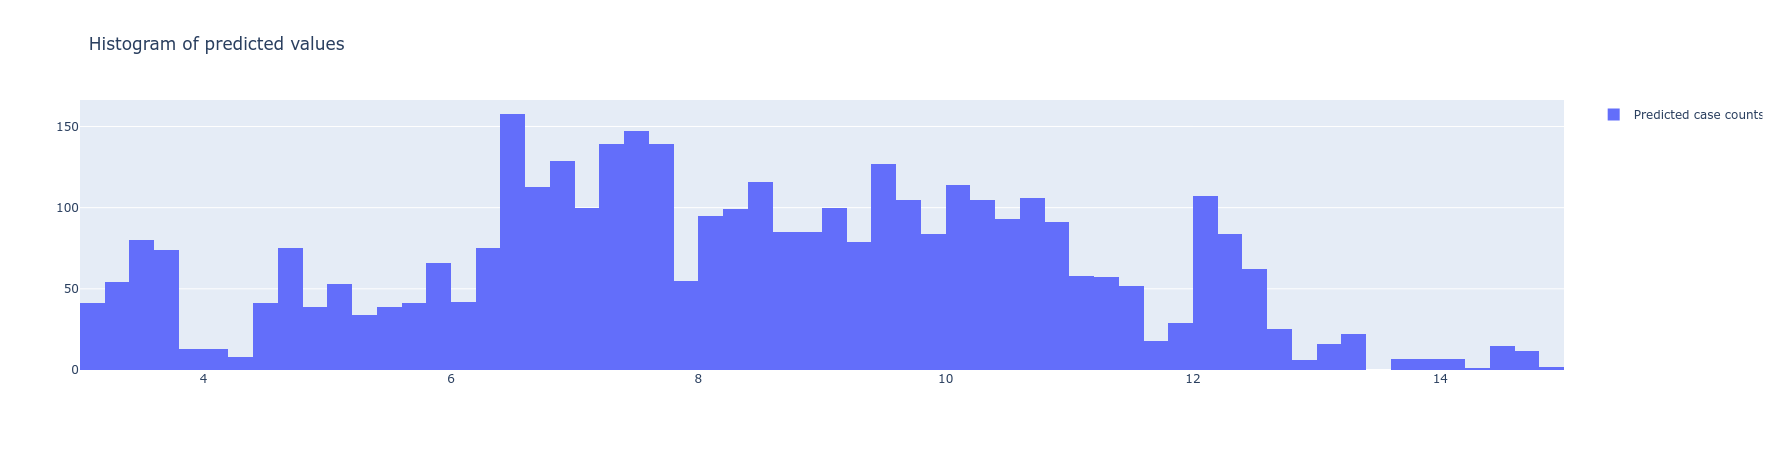

In [23]:
fig = go.Figure(data=[go.Histogram(x=np.log(test_y_pred),
                                   name='Predicted case counts'
                                  )]).update_layout(title='Histogram of predicted values',
                                                    showlegend=True
                                                   )
fig.show()

The histogram suggests that the predicted values are approximately exponentially distributed. This suggests the use of the mean squared log error (MSLE):

$$ \text{MSLE}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2. $$

According to the [scikit-learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error), the mean squared log error _"is best to use when targets having exponential growth, such as population counts, average sales of a commodity over a span of years etc."_ This is indeed the current use-case, where the dependent variable is a population count, and is monitored over time, with exponential growth as seen above.

The use of the MSLE also brings other advantages, such as a higher penalisation of under-prediction as opposed to over-prediction, due to the nature of the logarithmic function. It is also more robust to outliers, since once again, the logarithmic function reduces the effect of an outlier value.

In [24]:
print(f"Training set MSLE: {mean_squared_log_error(train_df.iloc[:, -1], train_y_pred)}")
print(f"Test set MSLE: {mean_squared_log_error(test_df.iloc[:, -1], test_y_pred)}")

Training set MSLE: 0.11005894231070731
Test set MSLE: 0.026584335659121914


Curiously, the error in the training set seems to be higher than the error in the test set.

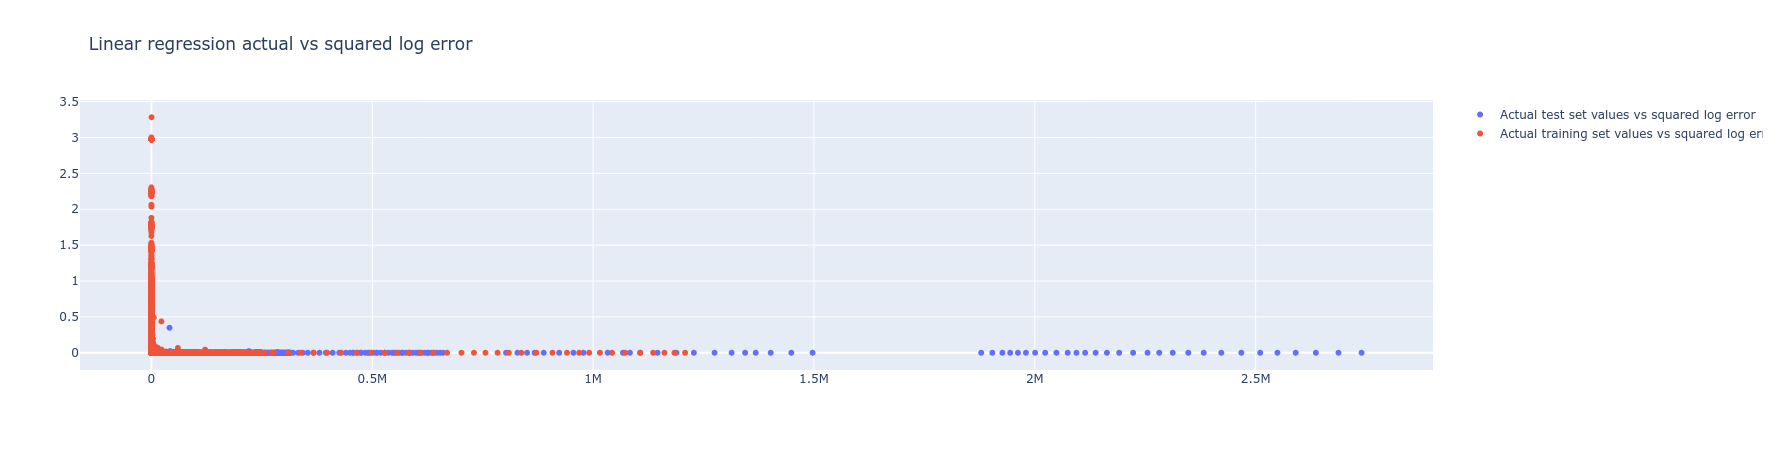

In [25]:
fig = go.Figure(data = [go.Scatter(x=test_df.iloc[:, -1],
                                   y=(np.log(1+test_df.iloc[:, -1]) - np.log(1+test_y_pred))**2,
                                   mode='markers',
                                   name='Actual test set values vs squared log error'
                                  ),
                        go.Scatter(x=train_df.iloc[:, -1],
                                   y=(np.log(1+train_df.iloc[:, -1]) - np.log(1+train_y_pred))**2,
                                   mode='markers',
                                   name='Actual training set values vs squared log error'
                                  )]
               ).update_layout(title='Linear regression actual vs squared log error',
                               showlegend=True
                              )
fig.show()

Plotting the values of the linear regression against the squared log error for both training set and test set (the plot can be manipulated above), it can be observed that the squared log error is highest for lower values. This suggests that the model is not doing well where case counts are much lower values, which would explain the lower test set error, since the training set contains values which are lower, since the training set consists of values preceding the test set values temporally.

This suggests that MSLE cannot be ruled out for comparison between models, which would be training and running on the same data. It also suggests that the simple linear regression model is not a very good model for smaller case counts. This model may however be used as a baseline, which will be doing going forward. As for its relevance with regards to prediction, by now, most countries have seen infections, and few are at levels low enough where the predictions may be a problem. Given the observations above, as time passes, we should in fact expect to see the error levels decrease. For a more directly comparable result however, we will have to train the model on both the training set and the validation set, then predict on the test set in order to obtain its results for a better basis of comparison, as we will be training all models on a concatenation of the training set to the validation set once selected.

In [26]:
regr_test = linear_model.LinearRegression()
regr_test.fit(train_val_df.iloc[:, :-1], train_val_df.iloc[:, -1])

LinearRegression()

In [27]:
regr_test_y_pred = regr_test.predict(test_df.iloc[:, :-1])
print(f"Test set MSLE: {mean_squared_log_error(test_df.iloc[:, -1], regr_test_y_pred)}")

Test set MSLE: 0.023494364376596893
